In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ast import literal_eval as lv
from data import PathPlanningCSVOperator

In [2]:
with open('config/config.json', 'r') as f:
    cfg = json.load(f)

# FMT*

In [3]:
ALG = 'fmt'
MAPS = {
    2: "Alternating Gaps",
    10: "Bugtrap Forest",
    13: "Forest",
    19: "Gaps Forest",
    24: "Maze",
    28: "Multi Bug Trap",
    37: "Bug Trap"
}
MODE = 'evaluation'
HW = cfg["fmt"]["heuristic_weights"] # FMT* specific (DONT CHANGE!)

In [4]:
dlist = []
for hw in HW:
    CSVOperator = PathPlanningCSVOperator(ALG, MODE, f'_hw_{hw}')
    df = pd.read_csv(CSVOperator.fpath)
    df["Any Path Found"] = df["Any Path Found"].astype('int')
    dlist.append(df)

# BIT*

In [37]:
bitdf = pd.read_csv('bit_star/results/evaluation_data/test.csv')

> **_NOTE:_**  Add grid-plot showing the maps used

## Solution Cost vs Execution Time

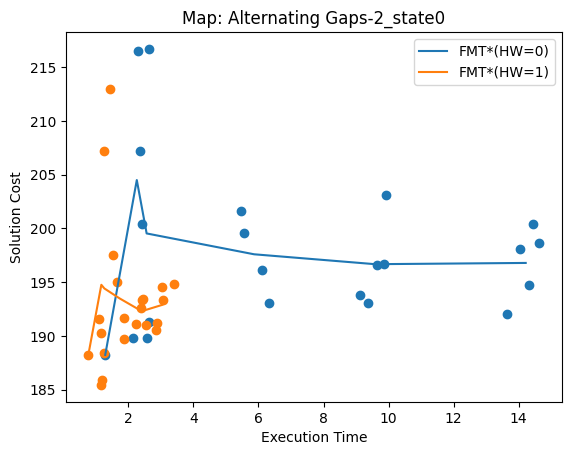

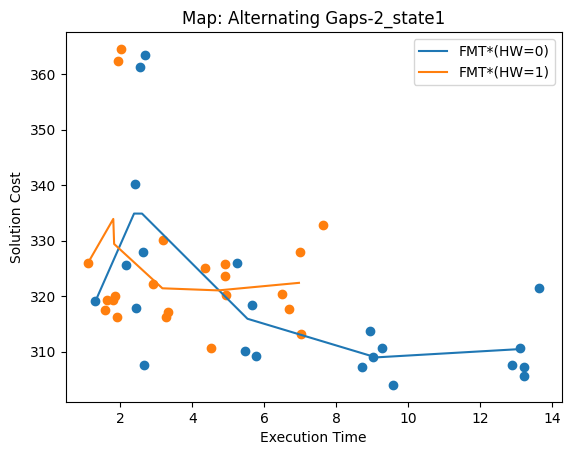

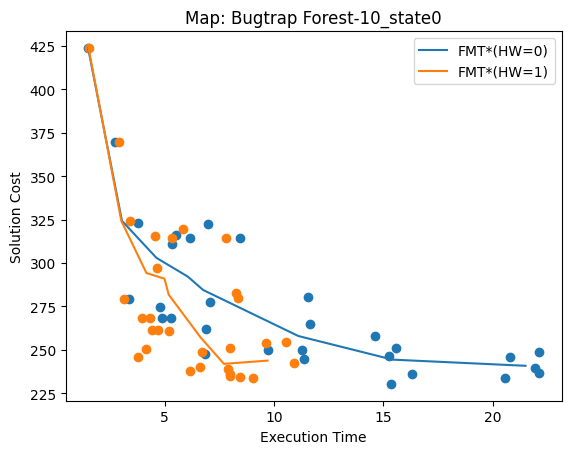

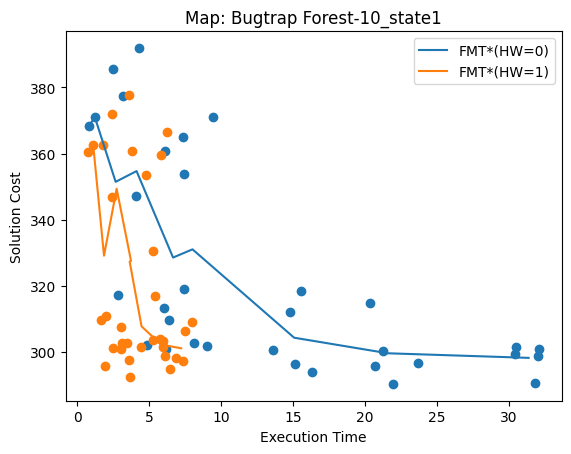

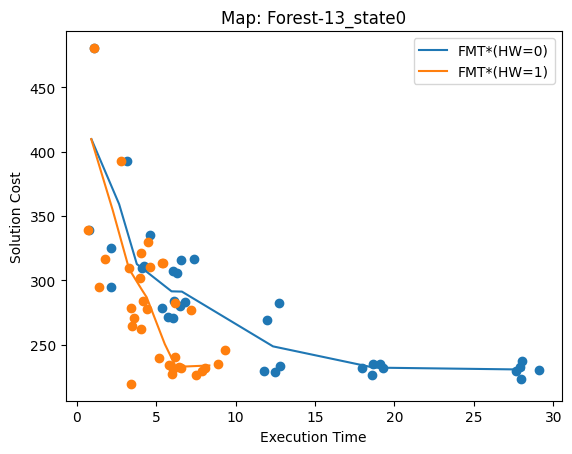

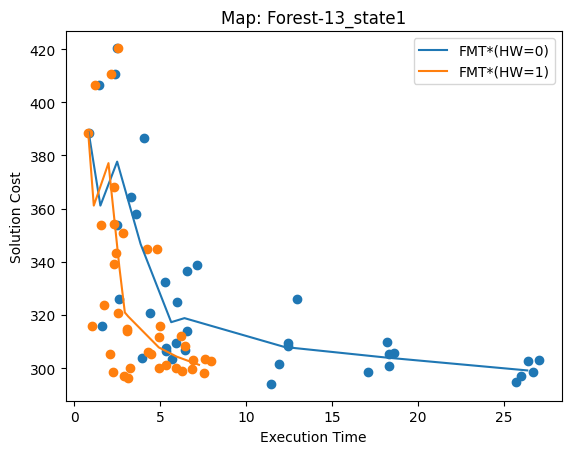

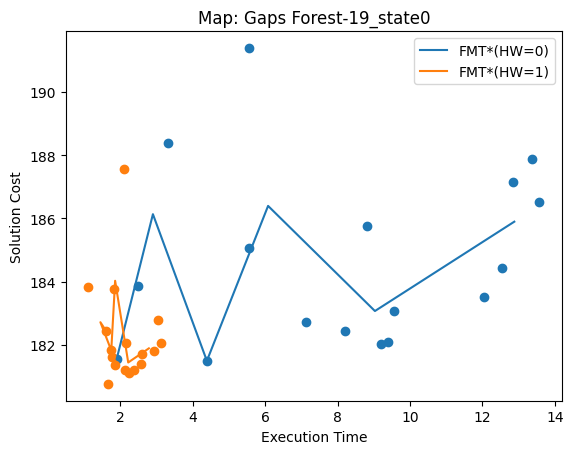

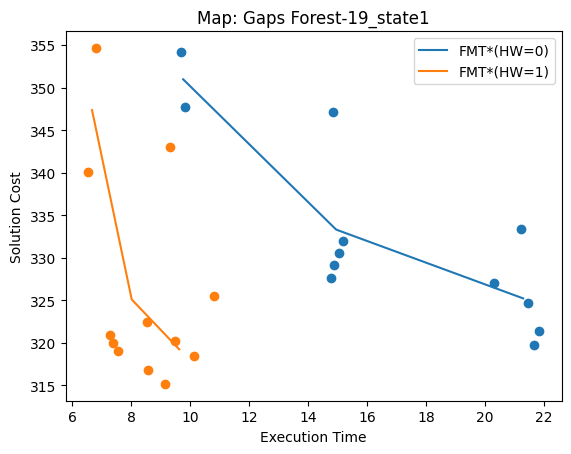

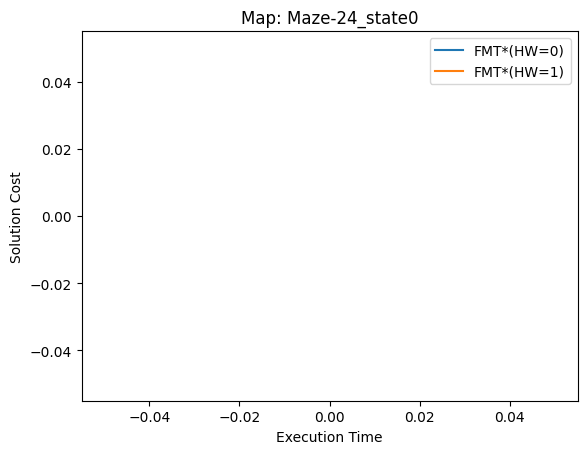

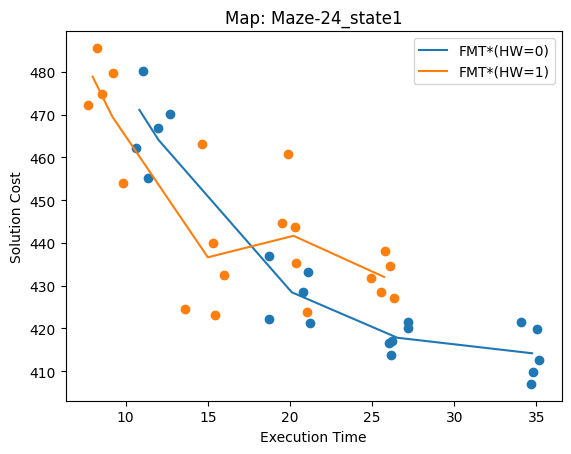

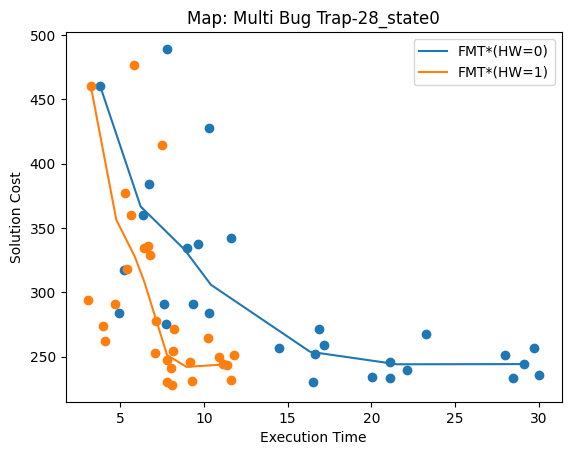

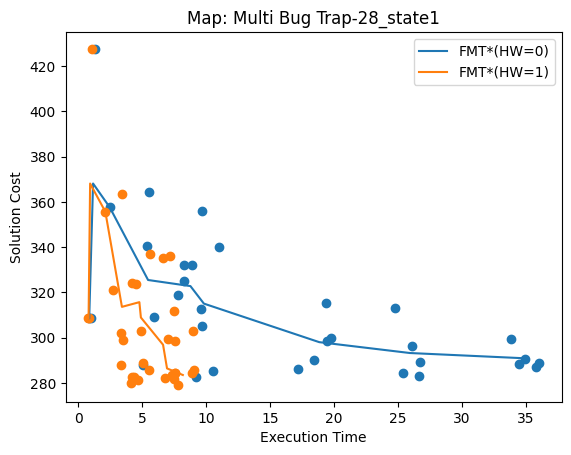

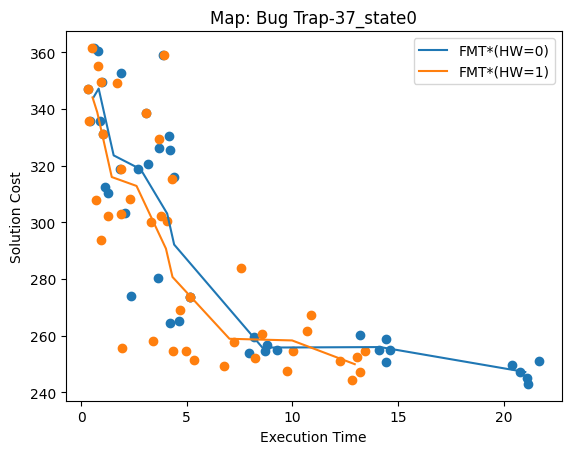

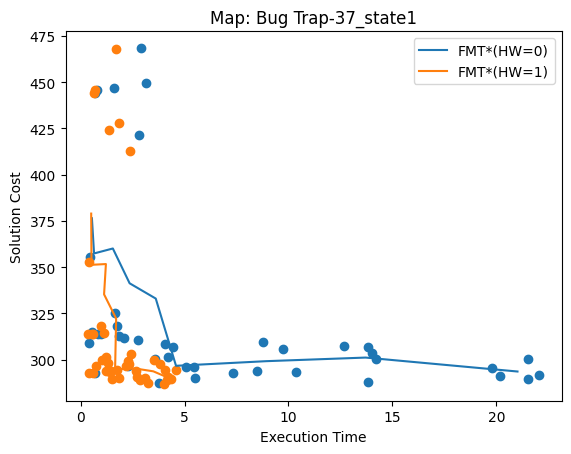

In [5]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots()
        ax.set_xlabel("Execution Time")
        ax.set_ylabel("Solution Cost")
        ax.set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        ax.legend(loc='upper right')
        # FMT*
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp) & (ddf["Any Path Found"])]
            scatterdf = mapi_data[["Timestep", "Current Path Cost"]]
            linedf = mapi_data[["Timestep", "Current Path Cost", "Batch Size"]].groupby(["Batch Size"]).mean()

            ax.scatter(scatterdf["Timestep"], scatterdf["Current Path Cost"])
            ax.plot(linedf["Timestep"], linedf["Current Path Cost"], label=f"FMT*(HW={HW[i]})")
        # BIT*
        mapi_data = bitdf[(bitdf["Map Id"] == idx) & (bitdf["Start Point"] == sp) & (bitdf["Any Path Found"])]
        plotdf = mapi_data[["Timestep", "Current Path Cost", "Iteration"]].groupby("Iteration").mean()
        ax.scatter(plotdf["Timestep"], plotdf["Current Path Cost"])
        ax.plot(plotdf["Timestep"], plotdf["Current Path Cost"], label=f"BIT*")
        # Save plot
        fig.savefig(f"results/scVet_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")

# Success Rate vs Execution Time

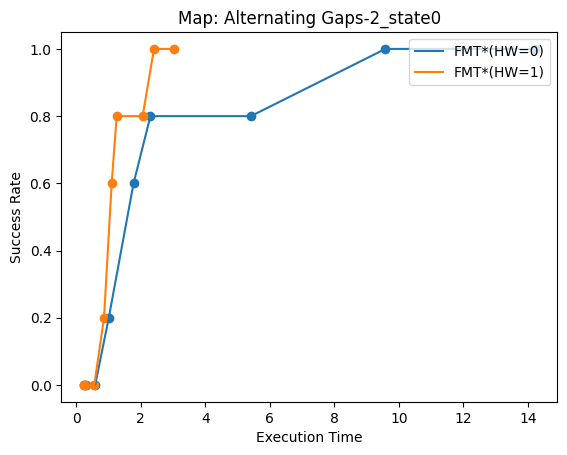

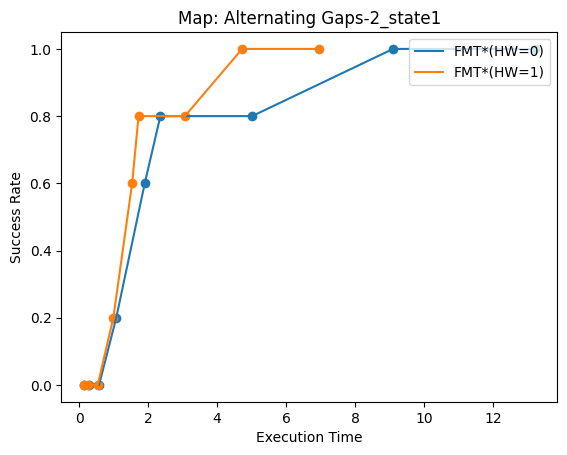

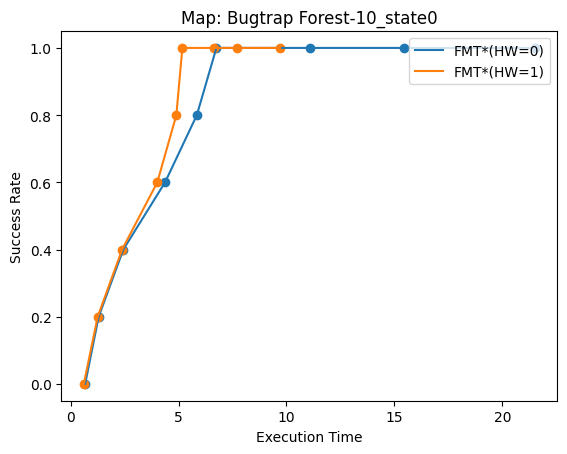

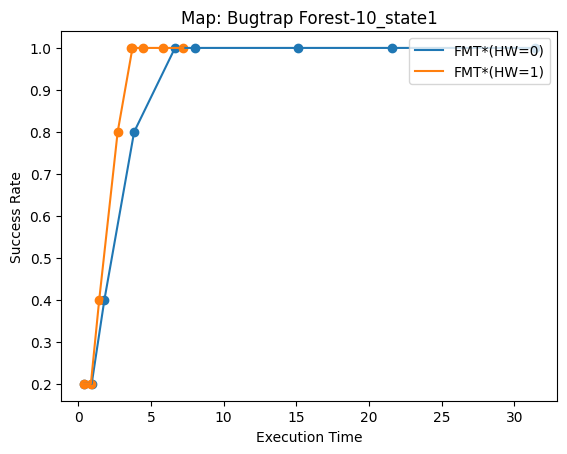

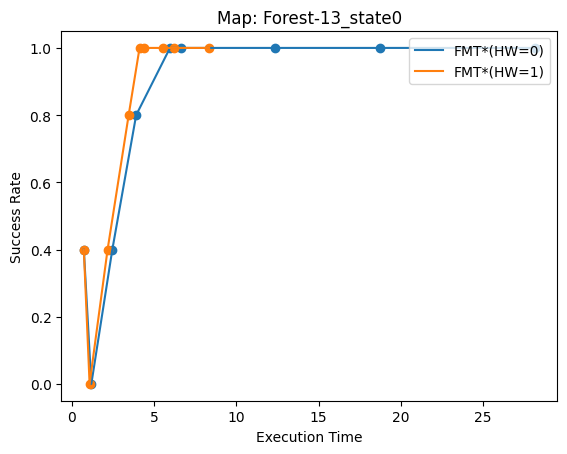

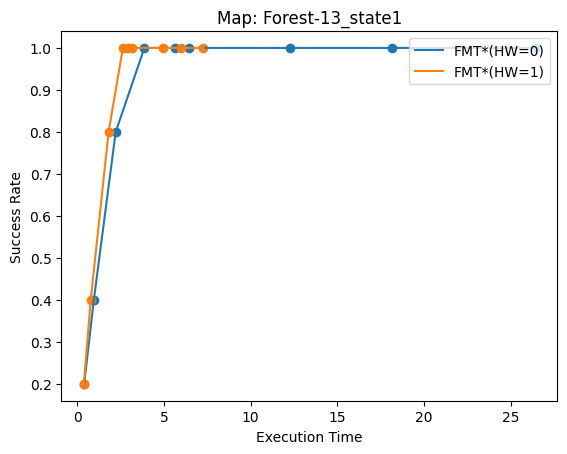

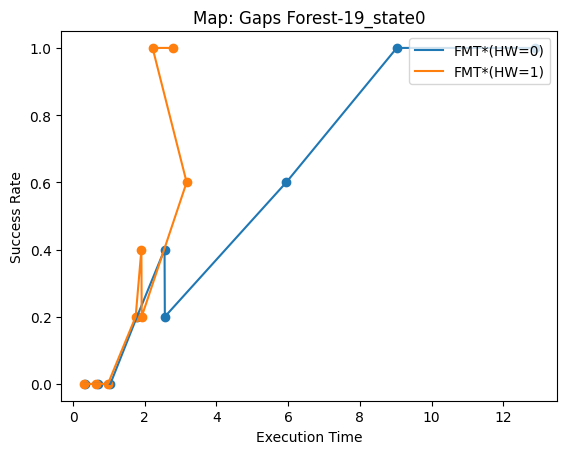

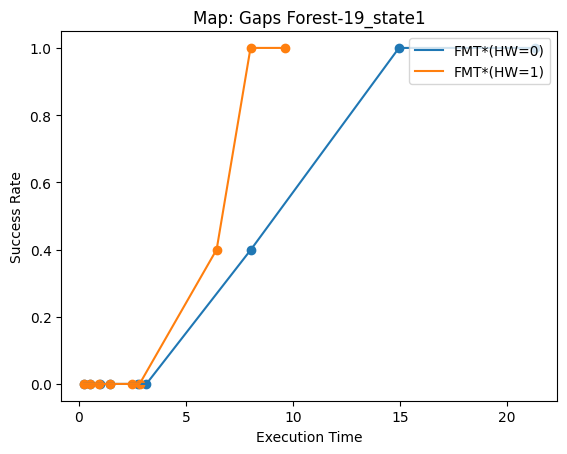

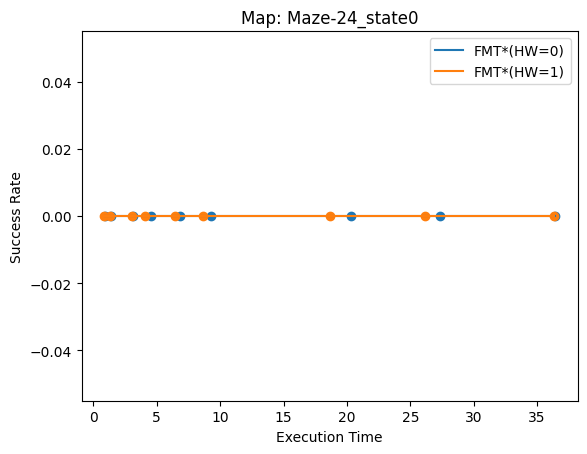

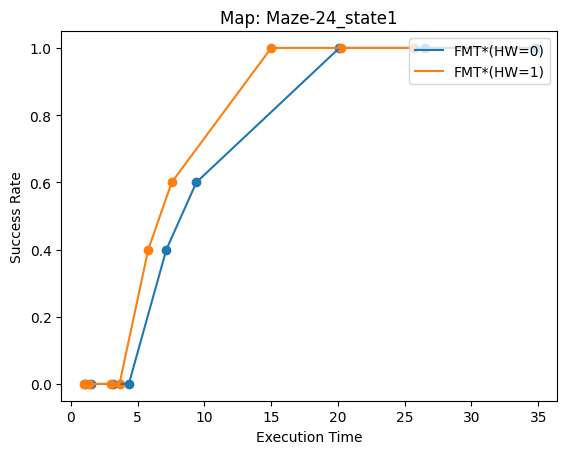

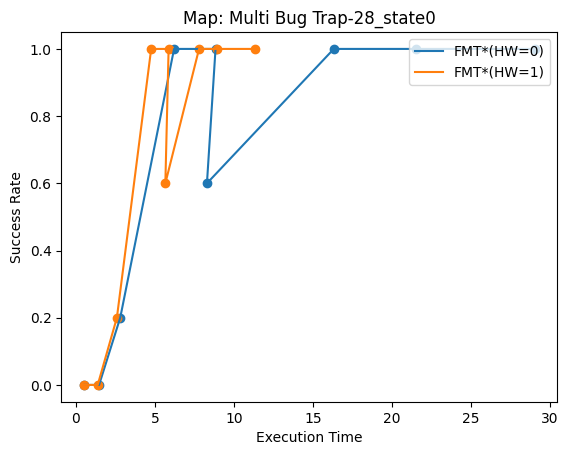

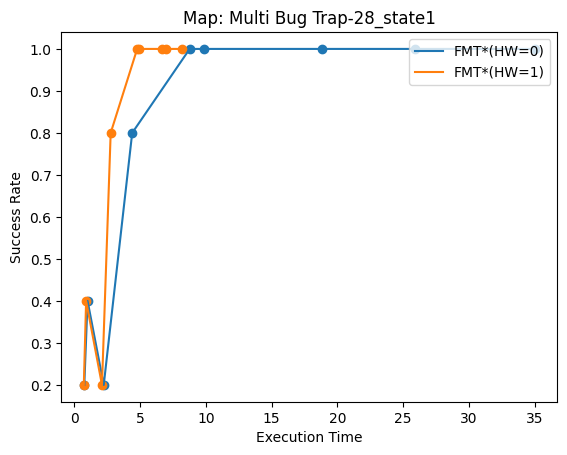

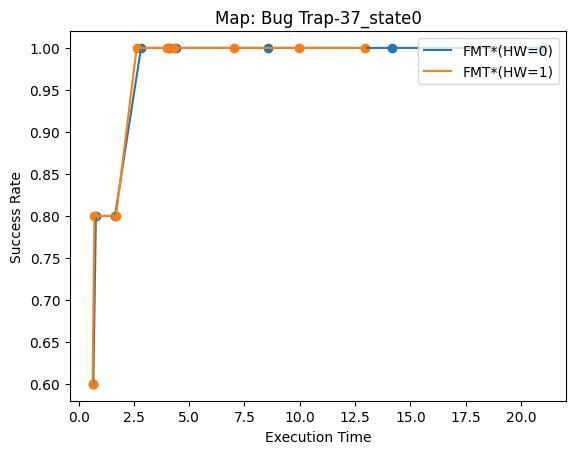

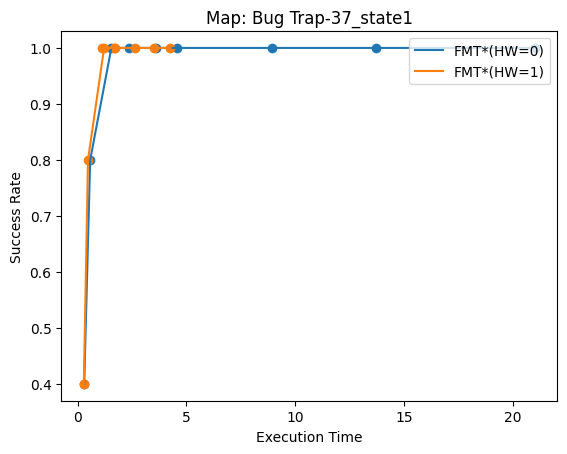

In [6]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots()
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp)]
            plotdf = pd.concat([
                        mapi_data[["Timestep", "Batch Size"]].groupby(["Batch Size"]).mean(),
                        mapi_data[["Any Path Found", "Batch Size"]].groupby(["Batch Size"]).sum()/cfg["runs_per_map"]
                    ], axis=1)

            ax.scatter(plotdf["Timestep"], plotdf["Any Path Found"])
            ax.plot(plotdf["Timestep"], plotdf["Any Path Found"], label=f"FMT*(HW={HW[i]})")
            ax.set_xlabel("Execution Time")
            ax.set_ylabel("Success Rate")
            ax.set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
            ax.legend(loc='upper right')
        fig.savefig(f"results/srVet_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")

# Sample Count vs Collision Check

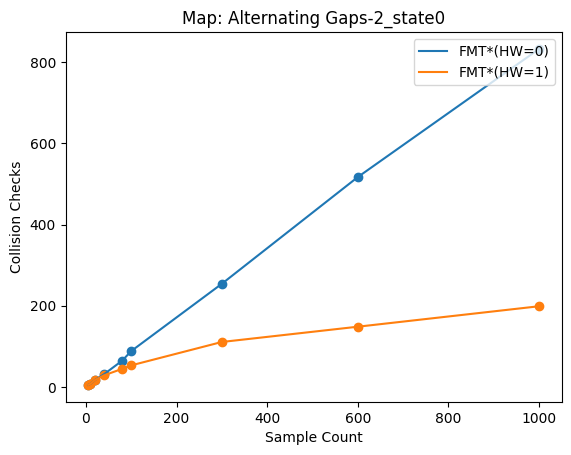

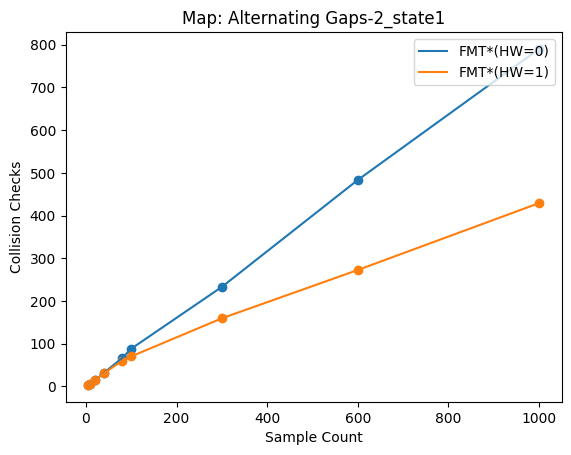

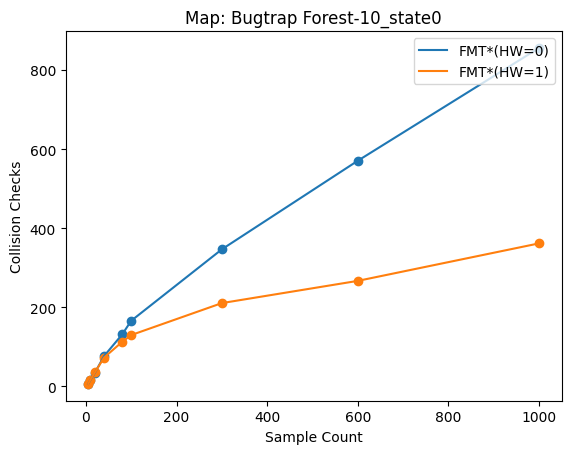

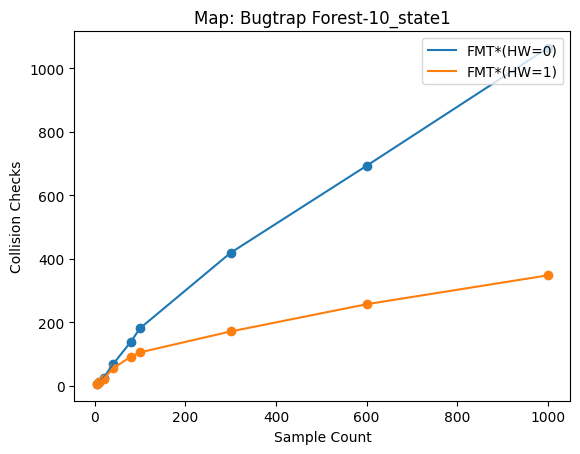

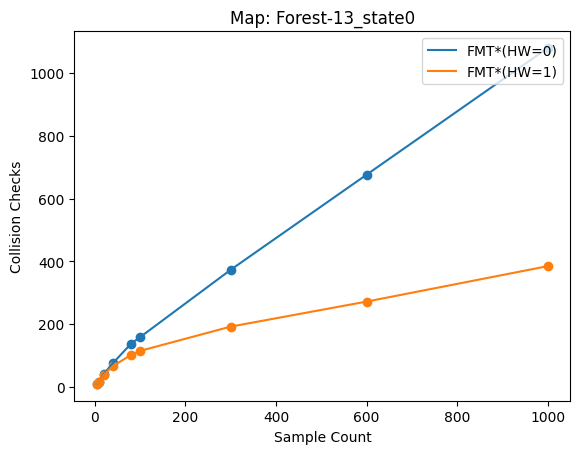

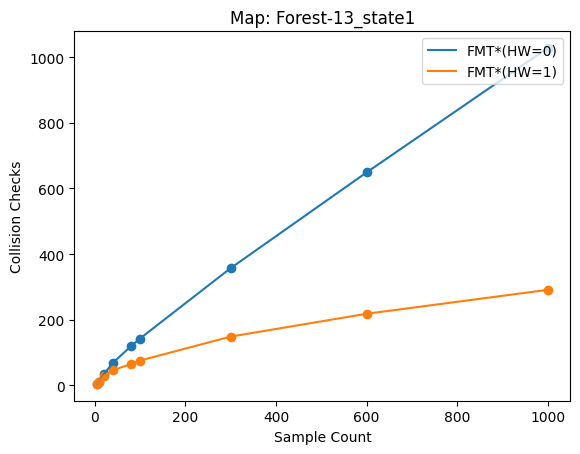

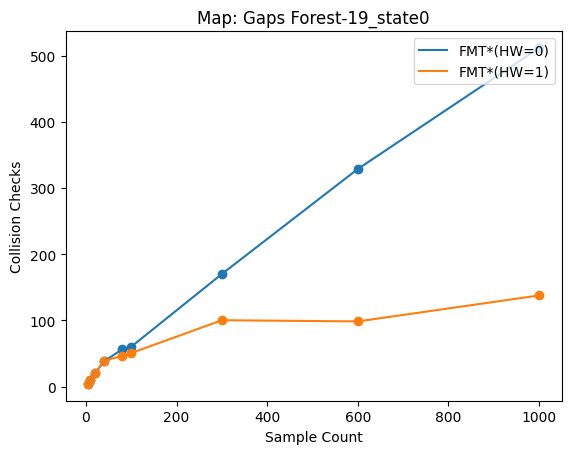

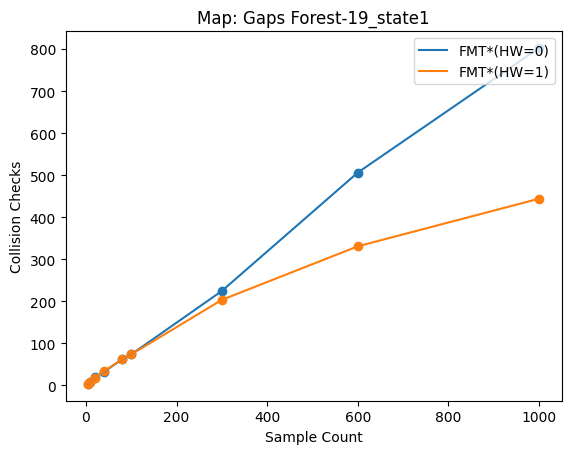

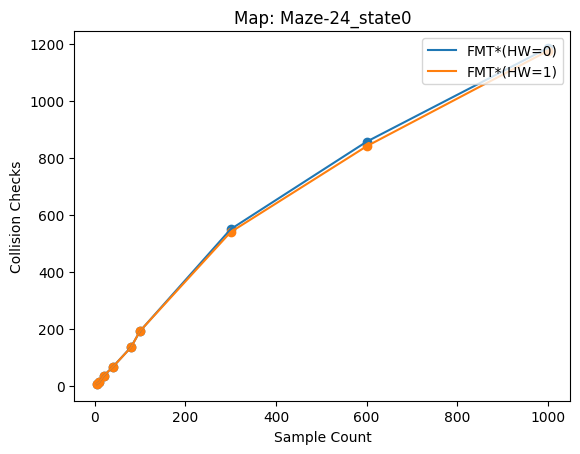

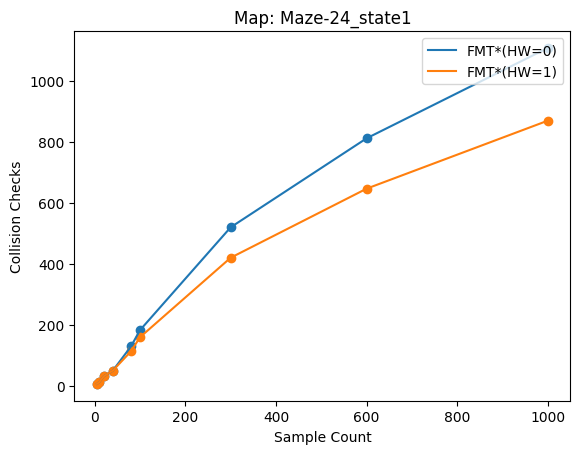

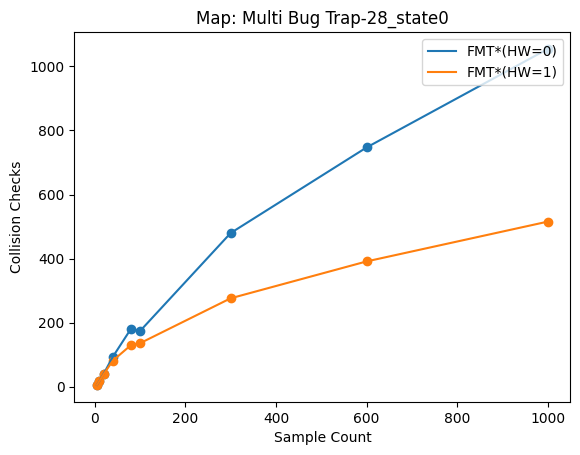

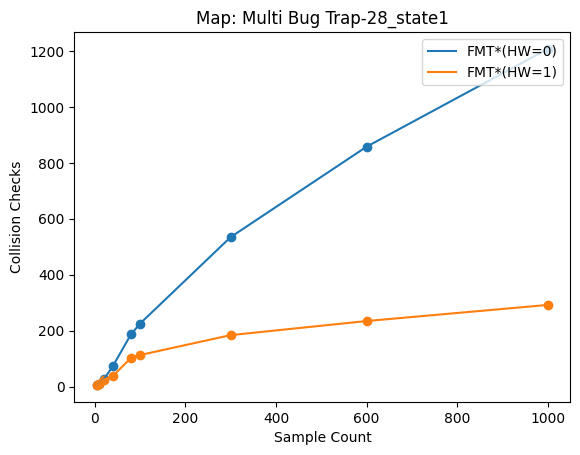

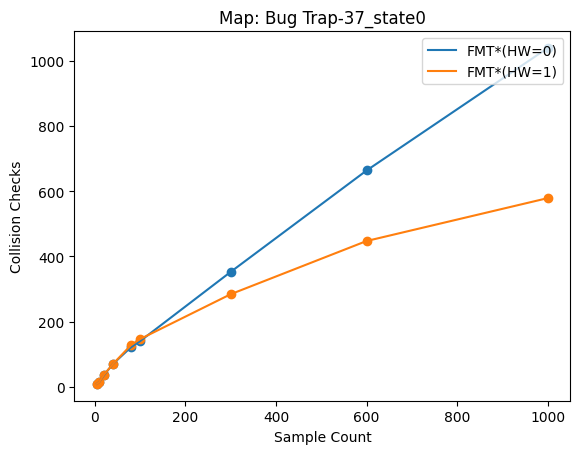

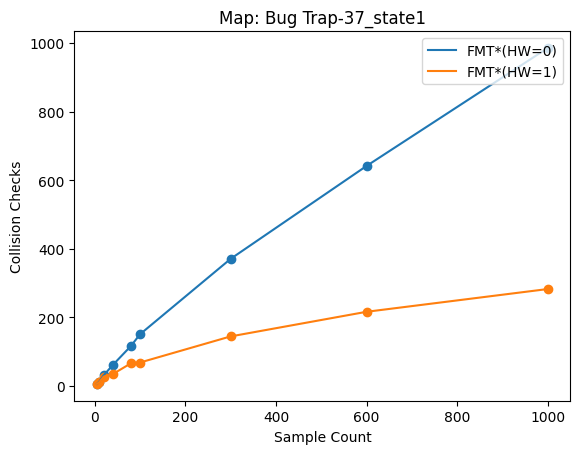

In [7]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots()
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp)]
            plotdf = mapi_data[["Batch Size", "Num Collision Checks"]].groupby("Batch Size").mean().reset_index()

            ax.scatter(plotdf["Batch Size"], plotdf["Num Collision Checks"])
            ax.plot(plotdf["Batch Size"], plotdf["Num Collision Checks"], label=f"FMT*(HW={HW[i]})")
            ax.set_xlabel("Sample Count")
            ax.set_ylabel("Collision Checks")
            ax.set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
            ax.legend(loc='upper right')
        fig.savefig(f"results/scVcc_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")